kmesh:  [200 200   1]
... kmesh is ready


/var/folders/yx/yyc7btkx3h1dwknwljj529r00000gn/T/ipykernel_65869/242561484.py:360: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  data1 = axs[1].pcolor(xmesh, ymesh, el_plot, cmap='plasma')


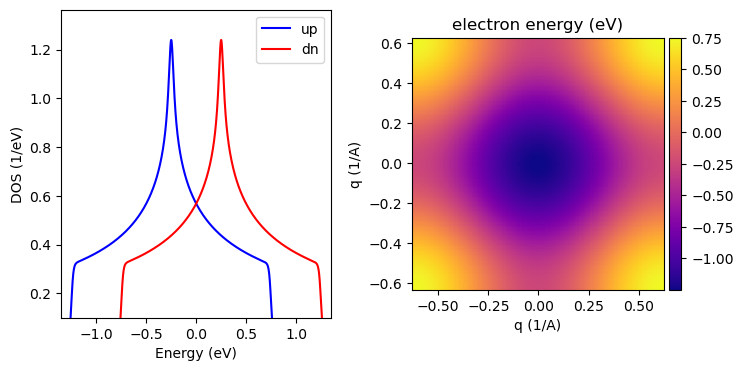

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba import jit, prange
import time

def kmesh_preparation(kmesh, cell_vec): 
    
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]
    rec_vec = np.zeros((3,3))
    k_vec  = np.zeros((num_kpoints,3))

    rec_vec[0]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[1], cell_vec[2])
    rec_vec[1]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[2], cell_vec[0])
    rec_vec[2]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[0], cell_vec[1])

    q = 0
    for q1 in range(-int(0.5 * kmesh[0]),  int(0.5 * kmesh[0])):
        for q2 in range(-int(0.5 * kmesh[1]),  int(0.5 * kmesh[1])):
            # to avoid divergence
            if(q1 == 0 and q2 == 0):
                k_vec[q] = (rec_vec[0] * q1/ kmesh[0]) + (rec_vec[1] * q2 / kmesh[1]) + np.array([0.01, 0.0, 0.0])
            else:
                k_vec[q] = (rec_vec[0] * q1/ kmesh[0]) + (rec_vec[1] * q2 / kmesh[1])
            q +=1
                
                
    print('... kmesh is ready')
    return k_vec 


def energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing):
    # prepare the energy contour for integration
    num_freq = ncol + 2 * nrow
    de = complex((e_fermi - e_low) / ncol, smearing / nrow)

    freq = np.zeros(num_freq, dtype=np.complex128)
    d_freq = np.zeros(num_freq, dtype=np.complex128)
    e_const = complex(e_low, 0)

    idx_x = 0
    idx_y = 1

    idx = 0
    for i in range(num_freq):
        if (i == nrow):
            idx_x = 1
            idx_y = 0
            idx = 0
            e_const = complex(e_low, smearing)
        elif (i == nrow + ncol):
            idx_x = 0
            idx_y = -1
            idx = 0
            e_const = complex(e_fermi, smearing)
        
        freq[i] = e_const + complex(idx * idx_x * (de).real, idx * idx_y * (de).imag)
        d_freq[i] = complex(idx_x * (de).real, idx_y * (de).imag)
        idx = idx+1

    return freq, d_freq



@jit(nopython=True)
def calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, Ham_K, selfen):
    
    num_kpoints = k_vec.shape[0]
    weight = 1/num_kpoints
 
    corr_greenK = np.zeros(2, dtype=np.complex128)
    r = index_temp[0] * cell_vec[0] + index_temp[1] * cell_vec[1]
    
    exchange = 0.0

    phase = np.zeros((num_kpoints), dtype=np.complex128)
    for e in range(num_kpoints):
        phase[e] = np.exp( 1j * np.dot(k_vec[e],r) )

    for num in range(num_freq):
        delta_i = 0
        greenR_ij = 0
        greenR_ji = 0

        for  e in range(num_kpoints):
            for z in range(2):
                #G = 1/(E - H)
                
                corr_greenK[z] = 1/((E[num] - Ham_K[e, z]) - selfen[z, e, num])  
                
            delta_i += weight * (Ham_K[e, 0] - Ham_K[e, 1] + selfen[0, e, num] - selfen[1, e, num])
            greenR_ij += weight * phase[e] * corr_greenK[1] 
            greenR_ji += weight * np.conj(phase[e]) * corr_greenK[0]
            
        dot_product = delta_i * greenR_ij * delta_i * greenR_ji 
        exchange -= (2/np.pi) * (dot_product * dE[num]).imag
       
    return exchange


@jit(nopython=True)
def calc_green(freq, k_vec, Ham_K, selfen, smearing):
    
    num_kpoints = k_vec.shape[0]
    num_freq = freq.shape[0]
 
    greenR = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    greenR_corr = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    
    for num in range(num_freq):
        for e in range(num_kpoints):
            for z in range(2):
                #G = 1/(E - H)
                greenR[z, e, num] += 1/(freq[num] - Ham_K[e, z] + 1j*smearing)
                greenR_corr[z, e, num] += 1/((freq[num] - Ham_K[e, z]) - selfen[z, e, num])
        
    greenR *= -(1/np.pi) 
    greenR_corr *= -(1/np.pi)
    
    return greenR, greenR_corr

        
    
    
def calc_electron(t, delta, e_fermi, cell_vec, k_vec): 
    
    num_kpoints = k_vec.shape[0]
    el_k = np.zeros((num_kpoints, 2), dtype=np.complex128)
    Ham_r = np.zeros((3, 3, 2))
    
    # nn hopping t 
    Ham_r[0, 1, 0] = t
    Ham_r[1, 0, 0] = t
    Ham_r[1, 2, 0] = t
    Ham_r[2, 1, 0] = t
    
    Ham_r[0, 1, 1] = t
    Ham_r[1, 0, 1] = t
    Ham_r[1, 2, 1] = t
    Ham_r[2, 1, 1] = t
    
    Ham_r[1, 1, 0] = -0.5 * delta - e_fermi # spin_up
    Ham_r[1, 1, 1] =  0.5 * delta - e_fermi # spin_dn
    
    #vectorized version of Fourier transform
    for i in range(-1, 2):
        for j in range(-1, 2):
            r = i * cell_vec[0] + j * cell_vec[1]
            k_dot_r = (k_vec @ r).reshape(num_kpoints, 1)
            phase = np.exp(-1j * k_dot_r)
            el_k += phase * Ham_r[i + 1, j + 1, :]
            
    return el_k





#Model of phonons and elph coupling g 
def calc_phonon(model, lambda_elph, dos_fermi, v, hw0, k_vec, verbose):
    num_kpoints = k_vec.shape[0]
    kB = 8.61733e-5 # eV/K
     
    if(model == 'D'):
        v = v * 1e10 #(m/s - > A/s) 
        hbar = 6.582e-16 # (eV * s)
        a = 5 # unit cell parameter A
        if(verbose):
            Tc = np.pi * hbar * v / (kB * a) 
            print("Debye model of phonons is used")
            print("Speed of sound (m/s):", v / 1e10)
            print("Debye temperature (K):",Tc)
                    
        ph_q = np.zeros((num_kpoints, 2))
        g = np.zeros(num_kpoints)
        for q in range(num_kpoints):
            q_abs = np.linalg.norm(k_vec[q])  # 1/A
            ph_q[q, 0] = hbar * v * q_abs #  eV  
            ph_q[q, 1] = hbar * v * q_abs 
            g[q] = np.sqrt(lambda_elph * hbar * q_abs * v / dos_fermi)  # eV 
                  
    elif(model == 'E'):
        if(verbose):
            Tc = hw0 / kB
            print("Einstein model of phonons is used")
            print("Phonon frequency (eV):", hw0)
            print("Einstein temperature (K):",Tc)
    
        ph_q = hw0 * np.ones((num_kpoints, 2))
        g = np.sqrt(lambda_elph * hw0 / dos_fermi) * np.ones(num_kpoints)
                
    else:
        print("Set the correct model!!!")
        return None
            
    return ph_q, g 


@jit(nopython=True, parallel=True)
def elph_selfen(g, kT, kmesh, freq, el_k, ph_q):
    
    def bose(kT, E):
        if(np.abs(E / kT) < 20):
            return 1.0 / (np.exp(E / kT) - 1)
        else:
            return 0.0  

    def fermi(kT,E):
        if(np.abs(E / kT) < 20):
            return 1 / (np.exp(E / kT) + 1)
        else:
            if E < 0:
                return 1.0
            else:
                return 0.0            

    num_freq = freq.shape[0]
    num_kpoints = kmesh[0] * kmesh[1]

    selfen = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    weight = 1 / num_kpoints
    
    delta = 0.005 # 50K

    el_k = el_k.reshape(kmesh[0], kmesh[1], 2)
    ph_q = ph_q.reshape(kmesh[0], kmesh[1], 2)
    g = g.reshape(kmesh[0], kmesh[1])

    for k1 in prange(kmesh[0]):
        for k2 in prange(kmesh[1]):
            k = k2 + (k1 * kmesh[1])
            for q1 in range(kmesh[0]):
                for q2 in range(kmesh[1]):
                    kq1 = (k1 + q1) % kmesh[0]
                    kq2 = (k2 + q2) % kmesh[1]

                    for z in range(2):
                        bose_term = bose(kT, ph_q[q1, q2, z].real)
                        fermi_term = fermi(kT, el_k[kq1, kq2, z].real)
                        el_energy = el_k[kq1, kq2, z]
                        ph_energy = ph_q[q1, q2, z]
                        g2_const = g[q1, q2]**2 
                    
                        for w in range(num_freq):         
                            selfen[z, k, w] += g2_const * ((bose_term + fermi_term) / (freq[w] - el_energy + ph_energy + 1j*delta) + \
                            (bose_term + 1 - fermi_term) / (freq[w] - el_energy - ph_energy + 1j*delta)) 

    selfen *= weight
    
    if(np.any(np.isnan(selfen))):
        print("There is a divergence!!!")
    
    return selfen  



@jit(nopython=True, parallel=True)
def elph_selfen_highT(lmbda, kT, kmesh, freq, el_k, dos_fermi):
    
    num_freq = freq.shape[0]
    num_kpoints = kmesh[0] * kmesh[1]

    selfen = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    weight = 1 / num_kpoints
    
    delta = 0.01 # 100K

    el_k = el_k.reshape(kmesh[0], kmesh[1], 2)

    for k1 in prange(kmesh[0]):
        for k2 in prange(kmesh[1]):
            k = k2 + (k1 * kmesh[1])
            for q1 in range(kmesh[0]):
                for q2 in range(kmesh[1]):
                    kq1 = (k1 + q1) % kmesh[0]
                    kq2 = (k2 + q2) % kmesh[1]

                    for z in range(2):
                        el_energy = el_k[kq1, kq2, z]
                        
                        for w in range(num_freq):
                            selfen[z, k, w] +=  1/ (freq[w] - el_energy + 1j*delta)

    selfen *= weight * 2 * kT * lmbda / dos_fermi
    
    return selfen  



@jit(nopython=True)    
def plot_dos(freq, energy_k, kT):
    
    def dirac_delta(kT,E_tot):
        E = E_tot.real
        if(np.abs(E/kT) < 20):
            delta = (np.exp(E/kT)/kT)/(1 + np.exp(E/kT))**2
        else:
            delta = 0
        return delta
    
    num_kpoints = energy_k.shape[0]
    num_enpoints = freq.shape[0]
    dos_F = np.zeros((2000, 2))
    
    for spin in range(2):
        for en in range(2000):
            for k in range(num_kpoints):        
                dos_F[en, spin] += dirac_delta(kT, freq[en] - energy_k[k, spin])
                
    return dos_F/num_kpoints

#############################################################################

t = -0.25 # hopping (in eV)
delta = 0.5 # spin splitting (in eV)
e_fermi = 0 # Fermi energy
smearing = 1e-4 # smearing for integration

ncol = 1000
nrow = 10
num_freq = ncol + 2 * nrow 

kmesh = np.array([200, 200, 1])
num_kpoints = np.prod(kmesh)
print('kmesh: ', kmesh)

cell_vec = np.array([[5.0,  0.0, 0.0],
                     [0.0,  5.0, 0.0],
                     [0.0,  0.0, 20.0]])



k_vec = kmesh_preparation(kmesh, cell_vec)
el_k = calc_electron(t, delta, e_fermi, cell_vec, k_vec)

e_low = np.min(el_k.real) - 0.2*delta # min energy for integration
e_max = -e_low

en_line = np.linspace(e_low, e_max, 2000)
dos = plot_dos(en_line, el_k, 0.01)
dos_F = dos[999]

el_plot = el_k[:,0].reshape(kmesh[0], kmesh[1]).real
k_plot = k_vec.reshape(kmesh[0], kmesh[1], 3)
xmesh = k_plot[:, :, 0]
ymesh = k_plot[:, :, 1]

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(8,4))
fig.subplots_adjust(wspace=0.3, hspace=0.1)
axs[0].plot(en_line, dos[:, 0], color='Blue', label='up') 
axs[0].plot(en_line, dos[:, 1], color='Red', label='dn') 
axs[0].set_xlim(np.min(en_line), np.max(en_line))
axs[0].set_ylim(0.1, np.max(dos) + 0.1 * np.max(dos))
axs[0].legend()
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('DOS (1/eV)')

data1 = axs[1].pcolor(xmesh, ymesh, el_plot, cmap='plasma')
axs[1].set_title('electron energy (eV)')
axs[1].set_xlabel('q (1/A)')
axs[1].set_ylabel('q (1/A)')
axs[1].set_aspect('equal')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(data1, cax=cax)


results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

fig.savefig(os.path.join(results_dir, 'el_DOS.png'), dpi=300, facecolor='w', transparent=False, bbox_inches='tight')

In [13]:
print("Occupation:", np.sum(dos[:1000, 0]) * (en_line[1] - en_line[0]))
print('DOS on Fermi', dos_F)

Occupation: 0.6915594117208288
DOS on Fermi [0.56872123 0.56766442]


In [ ]:
# lambda_elph = d_const**2 N_F/(2 m v**2)
lambda_elph = 0.5
ph_q, g_q = calc_phonon('D', lambda_elph, dos_F[0], 500, 0.05, k_vec, True)

ph_plot = ph_q[:,0].reshape(kmesh[0], kmesh[1])
g_plot =  g_q.reshape(kmesh[0], kmesh[1])


fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(8,8))
fig.subplots_adjust(wspace=0.6, hspace=0.1)
data1 = axs[0, 0].pcolor(xmesh, ymesh, ph_plot, cmap='plasma')
axs[0, 0].set_title('phonon energy (eV)')
axs[0, 0].set_xlabel('q (1/A)')
axs[0, 0].set_ylabel('q (1/A)')
axs[0, 0].set_aspect('equal')
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(data1, cax=cax)


data2 = axs[0, 1].pcolor(xmesh, ymesh, g_plot , cmap='plasma')
axs[0, 1].set_title(f'lambda: {lambda_elph:02f}')
axs[0, 1].set_xlabel('q (1/A)')
axs[0, 1].set_ylabel('q (1/A)')
axs[0, 1].set_aspect('equal')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(data2, cax=cax)

axs[1, 0].plot(np.linalg.norm(k_plot, axis=2).diagonal(), ph_plot.diagonal())
axs[1, 0].set_ylabel('g (eV)')
axs[1, 0].set_xlabel('q (1/A)')

axs[1, 1].plot(np.linalg.norm(k_plot, axis=2).diagonal(), g_plot.diagonal())
axs[1, 1].set_ylabel('g (eV)')
axs[1, 1].set_xlabel('q (1/A)')
    
fig.savefig(os.path.join(results_dir, 'ph_dispertion.png'), dpi=300, facecolor='w', transparent=False, bbox_inches='tight')

In [ ]:
selfen =  elph_selfen_highT(0.5, 100 * 0.00008617, kmesh, en_line, el_k, dos_F[0])
selfen_av = np.sum(selfen, axis=1)/num_kpoints
plt.plot(en_line, selfen_av[0].real)
plt.plot(en_line, selfen_av[0].imag)

In [ ]:
#plot DOS
T = np.array([100, 300])
t_length = T.shape[0]
lambda_elph = 0.5

dos_corr = np.zeros((t_length, 2, en_line.shape[0]))

# ph_q, g_q = calc_phonon('D', lambda_elph, dos_F[0], 500, 0.05, k_vec, True)
# selfen = elph_selfen(g_q, T*0.00008617, kmesh, en_line, el_k, ph_q)

for i in range(t_length):
    selfen =  elph_selfen_highT(lambda_elph, T[i] * 0.00008617, kmesh, en_line, el_k, dos_F[0])
    green, green_corr = calc_green(en_line, k_vec, el_k, selfen, smearing)
    dos_corr[i] = np.sum(green_corr, axis = 1).imag/num_kpoints

print('Done!')

In [ ]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(en_line, dos[:, 0], color='Blue', label='0')
ax.plot(en_line, dos[:, 1], color='Blue')

ax.plot(en_line, dos_corr[0, 0], color='Red', label=T[0])
ax.plot(en_line, dos_corr[0, 1], color='Red')

ax.plot(en_line, dos_corr[1, 0], color='Orange', label=T[1])
ax.plot(en_line, dos_corr[1, 1], color='Orange')
ax.legend()

In [ ]:
# dispersion along M - X - G - M
el_k_new = el_k.reshape(kmesh[0], kmesh[1], 2).real

shift_x = int(0.5 * kmesh[0])
shift_y = int(0.5 * kmesh[1])

num_points = kmesh[0] + shift_y
disp_el = np.zeros((num_points, 2))

for i in range(num_points):
    if(i <= shift_x):
        disp_el[i] = el_k_new[i, 0].real
        
    elif(i > shift_x and i < shift_x + shift_y):
        disp_el[i] = el_k_new[shift_x, i - shift_x]
        
    else:
        disp_el[i] = el_k_new[shift_x - i, shift_y - i]
 

###########
T = 100
lambda_elph = 0.5
# ph_q, g_q = calc_phonon('D', lambda_elph, dos_F[0], 500, 0.05, k_vec, True)
# selfen = elph_selfen(g_q, T*0.00008617, kmesh, en_line, el_k, ph_q)

selfen =  elph_selfen_highT(lambda_elph, T * 0.00008617, kmesh, en_line, el_k, dos_F[0])
green, green_corr = calc_green(en_line, k_vec, el_k, selfen, smearing)
print(np.min(green[0].imag), np.max(green[0].imag))
print(np.min(green_corr[0].imag), np.max(green_corr[0].imag))



plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
from mpl_toolkits.axes_grid1 import make_axes_locatable

spectral_el = np.zeros((2, num_points, en_line.shape[0]))
green_corr_new = green_corr.reshape(2, kmesh[0], kmesh[1], en_line.shape[0])

for i in range(num_points):
    if(i <= shift_x):
        spectral_el[:, i] = green_corr_new[:, i, 0].imag
        
    elif(i > shift_x and i < shift_x + shift_y):
        spectral_el[:, i] = green_corr_new[:, shift_x, i - shift_x].imag
        
    else:
        spectral_el[:, i] = green_corr_new[:, shift_x - i, shift_y - i].imag
   
spectral_el = np.sum(spectral_el, axis=0)

xmesh, ymesh = np.meshgrid(np.arange(num_points), en_line)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.pcolor(xmesh, ymesh, spectral_el.T, shading='auto', cmap='Blues', vmin=0, vmax=10)
# ax.plot(disp_el[:, 0], color='Red')
# ax.plot(disp_el[:, 1], color='Red')
ax.set_ylabel('Energy (eV)')
ax.set_xticks([-1, shift_x, kmesh[0], kmesh[0] + shift_x])
ax.set_xticklabels(['M', 'X', 'G', 'M'])
ax.grid(color='black', linestyle='dotted', linewidth=1, axis='x')
fig.savefig(os.path.join(results_dir, 'spectral_function.png'), dpi=400, facecolor='w', transparent=False, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(7,4))
fig.subplots_adjust(wspace=0.01, hspace=0.1)
axs[0].pcolor(xmesh, ymesh, spectral_el.T, shading='auto', cmap='Blues', vmin=0, vmax=10)
# axs[0].plot(disp_el[:, 0], color='Red')
# axs[0].plot(disp_el[:, 1], color='Red')
axs[0].set_ylabel('Energy (eV)')
axs[0].set_xticks([-1, shift_x, kmesh[0], kmesh[0] + shift_x])
axs[0].set_xticklabels(['M', 'X', 'G', 'M'])
axs[0].grid(color='black', linestyle='dotted', linewidth=1, axis='x')
axs[0].set_ylim([e_low, e_max])
axs[0].set_xlim([-1, kmesh[0] + shift_x])

axs[1].plot(dos[:, 0], en_line, color='Red', label='0 K')
axs[1].plot(dos[:, 1], en_line, color='Red')
axs[1].plot(dos_corr[0, 0], en_line, color='steelblue', label='100 K')
axs[1].plot(dos_corr[0, 1], en_line, color='steelblue')

axs[1].plot(dos_corr[1, 0], en_line, color='forestgreen', label='300 K')
axs[1].plot(dos_corr[1, 1], en_line, color='forestgreen')
axs[1].set_ylim([e_low, e_max])
axs[1].set_xlim([0.1, 2.8])
axs[1].set_xlabel('DOS (states/eV)')
axs[1].set_yticks([])
axs[1].legend(fontsize=12)


fig.savefig(os.path.join(results_dir, 'spectral_function.png'), dpi=300, facecolor='w', transparent=False, bbox_inches='tight')

In [9]:
# selected exchange
freq = np.linspace(e_low, e_fermi, ncol)

index_temp = np.array([1, 0])
E, dE = energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing)

T = 10
selfen = elph_selfen_highT(0.1, T * 0.00008617, kmesh, freq, el_k, dos_F[0])
selfen = np.pad(selfen, [(0, 0), (0, 0),(nrow, nrow)])
J = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen)
print(J)

0.03657077682935052


In [ ]:
# plot line
T = np.linspace(0, 20, 10) 

freq = np.linspace(e_low, e_fermi, ncol)
index_temp = np.array([1, 0])
E, dE = energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing)

for i in range(10):
#     selfen = elph_selfen(g_q, T[i] * 0.00008617, kmesh, freq, el_k, ph_q)
#     selfen = np.pad(selfen, [(0, 0), (0, 0),(nrow, nrow)])
#     J = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen)
    
    selfen_highT = elph_selfen_highT(0.1, T[i] * 0.00008617, kmesh, freq, el_k, dos_F[0])
    selfen_highT = np.pad(selfen_highT, [(0, 0), (0, 0),(nrow, nrow)])
    J_highT = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen_highT)
    
    print('{0.real:.4f}'.format(T[i]), '{0.real:.4f}'.format(J_highT))

In [ ]:
#plot 2d map
freq = np.linspace(e_low, e_fermi, ncol)
index_temp = np.array([1, 0])
E, dE = energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing)

v = np.linspace(1000, 3000, 10) # sound velocity (in m/c)
T = np.linspace(10, 300, 10)
data = np.zeros((10,10), dtype=np.float64)

for i in range(10):
    for j in range(10):
        d  = 0.05 * v[i] /410 
        ph_q, g_q, lambda_elph = calc_phonon('D', d, v[i], 0.01, k_vec, el_k, False)
        selfen = elph_selfen(g_q, T[j]*0.00008617, kmesh, freq, el_k, ph_q)
        selfen = np.pad(selfen, [(0, 0), (0, 0),(nrow, nrow)])
        J = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen)
        data[i, j] = J
        print(v[i], T[j], J, lambda_elph)
    

    
    
xmesh, ymesh = np.meshgrid(T, v)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
im = ax.pcolor(xmesh, ymesh, data.T, shading='auto', cmap='inferno', vmin=5, vmax=70)
ax.contour(xmesh, ymesh, data.T, levels=6, colors='black', linewidths=0.5, linestyles='dashed')
ax.set_xlabel('T (K)')
ax.set_ylabel('v (m/c)')
# ax.set_xticks([60, 120, 180, 240, 300])
# ax.set_yticks([1000, 1500, 2000, 2500, 3000])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
fig.savefig('phase_diagram.png', dpi=300, facecolor='w', transparent=False, bbox_inches='tight')
fig.savefig(os.path.join(results_dir, 'phase_diagram.png'), dpi=400, facecolor='w', transparent=False, bbox_inches='tight')